# Reinforcement Learning Python Workshop 

In this notebook, we aim to explore the concepts/frameworks for developing reinforcement learning models and learn more about their applications in solving IoT related problems.

### Firstly, what is Reinforcement Learning?

Reinforcement Learning is a machine learning paradigm that trains an "agent" by rewarding desired behavior and punishing undesired behavior. Essentially, the agent's job is to complete a task within its given "environment", but rather than directly giving the agent instructions on the best way to do so, the agent interacts with the environment by exploring each possible "state". As the agent performs different "actions" to reach each state, it will receive "rewards" or penalties and learn the patterns of the environment. As it continues to learn, the RL agent will attempt to maximize the total rewards it receives in its environment, in transitioning from the very first state to the very last state.

Some key terms to know when working with RL:

| Key Terms | Definitions |
|:--------:|:--------:|
|  Agent   |  The learner/decision maker that interacts with the environment   |
|  Environment   |  The external sytem that the RL agent interacts with   |
|  State   |  A representation of a scenario/condition in the environment   |
|  Action   |  A set of decisions the RL agent can make, given its current state   |
|  Reward   |  A numerical value that the environment provides as feedback to the RL agent, based on the action. Positive value implies desired behavior, negative value implies undesired behavior   |

A brief diagram showing the RL process:

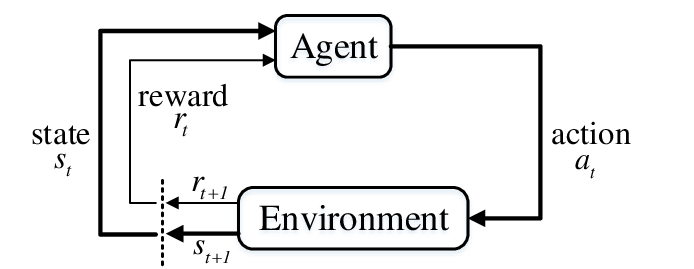

### How can we apply Reinforcement Learning to an IoT application?

The Internet of Things (IoT) sector refers to the network of interconnected devices with sensors, processing ability and advanced software technologies that allow data transmission to other devices/servers through various communication protocols. Reinforcement Learning can be used in many ways to automate and optimize these processes. 

Imagine a scenario where we want to train a self-driving car, rigged with IoT sensors/cameras/GPS, to autonomously drive a target distance down the highway, while minimizing the chance of colliding into other obstacles. How could we create a basic RL model to simulate this scenario?

In [102]:
# Loading in some basic Python libraries
# Make sure to run pip install gym beforehand to get the gym package
import gym
from gym import spaces
import numpy as np

### Implementing the RL Environment

Let's begin by defining an RL environment for the autonomous driving scenario, described above. 

Using the data generated by the IoT devices on the car, such as the vehicle position, vehicle speed, target position, current lane, obstacle position, etc., the vehicle can respond with actions like lane changing left/right or speeding up/slowing down. These describe the state (observation) and action spaces of the environment. 

The environment will then evaluate the actions taken by the vehicle and calculate the corresponding reward, based on the current state. Successfully reaching the target position will yield a great positive reward, while being in the same lane as an upcoming obstacle yields a great negative reward. We can add other factors like speed adjustment by implementing a small negative reward for each timestep, which will encourage the vehicle to reach the target position as fast as possible, while staying under the max speed limit. 

Finally, we need the environment to reset back to its initial state, once the episode ends. In our environment, the episode completes when the vehicle successfully reaches its target position.

In summary, we need to implement a class for our RL environment with the following functions:

- Initializing States/Actions: Creating Action and Observation/State Spaces

- Step Function: Defining how the actions taken by the agent affect the state + calculating reward

- Reset Function: Resetting all state observations and returning to initial state

By inheriting these default properties from the OpenAI ```gym``` environment, we can easily customize a class to simulate our autonomous driving scenario!

In [103]:
class AutonomousDrivingEnv(gym.Env):
    def __init__(self):
        super(AutonomousDrivingEnv, self).__init__()
        
        # Define action and observation spaces
        # 4 Discrete Actions: Lane Change Left, Lane Change Right, Speed Up, Slow Down
        self.action_space = spaces.Discrete(4) 
        # 6 State Variables/Observations: Vehicle Position, Vehicle Speed, Obstacle Position + Lane, Target Position, Current Lane
        self.observation_space = spaces.Box(low=np.array([0.0, 1.0, 0.0, 0.0, 0, 0]), high=np.array([1000.0, 10.0, 1000.0, 1000.0, 2, 2]), dtype=np.float32)
        
        # Initialize state variables
        self.vehicle_position = 0.0
        self.vehicle_speed = 1.0
        self.obstacle_position = -1 # No obstacle yet
        self.target_position = 1000.0
        self.current_lane = 1
        self.obstacle_lane = -1
        
    def step(self, action):
        # Implement how the environment responds to actions taken by the agent
        # Calculate the reward
        # Update the state 
        if action == 1:  # Left lane change
            self.current_lane = max(0, self.current_lane - 1)
        elif action == 2:  # Right lane change
            self.current_lane = min(2, self.current_lane + 1)
        elif action == 3:  # Speed up
            self.vehicle_speed = min(self.vehicle_speed + 1, 10)
        elif action == 4:  # Speed down
            self.vehicle_speed = max(self.vehicle_speed - 1, 1)
            
        # Update vehicle position based on speed
        self.vehicle_position += self.vehicle_speed

        # Update obstacle position (randomly simulate obstacles)
        if np.random.rand() < 0.3:  # 30% chance of an obstacle appearing
            self.obstacle_lane = np.random.randint(0, 2)
            self.obstacle_position = np.random.randint(0, 1000)

        # Used helper function to define reward for clarity
        reward = self._calculate_reward()
        
        # Checking if episode is done
        done = (self.vehicle_position >= self.target_position)

        # Returning the observation vector and additional info
        return self._get_state(), reward, done, {}

    def _calculate_reward(self):
        if self.vehicle_position >= self.target_position:
            return 100  # Positive reward for reaching the target
        elif self.obstacle_position >= 0 and self.current_lane == self.obstacle_lane and self.vehicle_position <= self.obstacle_position:
            return -100  # Negative reward for colliding with an obstacle
        else:
            return -1  # Small negative reward for each time step
    
    def reset(self):
        # Reset the environment to an initial state
        self.vehicle_position = 0.0
        self.vehicle_speed = 1.0
        self.obstacle_position = -1
        self.target_position = 1000.0
        self.current_lane = 1
        self.obstacle_lane = -1
        # Return state
        return self._get_state()
    
    def _get_state(self):
        # Return the current state/observation vector as dictionary
        return {
            'vehicle_position': self.vehicle_position,
            'vehicle_speed': self.vehicle_speed,
            'obstacle_position': self.obstacle_position,
            'target_position': self.target_position,
            'current_lane': self.current_lane,
            'obstacle_lane': self.obstacle_lane
        }

### Testing our Environment with a Random Agent

For testing our custom RL environment, we will implement a very simple Random Agent algorithm like so:

In [104]:
# Create an instance of the environment
env = AutonomousDrivingEnv()

# Define and set up the RandomAgent
class RandomAgent:
    def __init__(self, action_space):
        self.action_space = action_space

    def act(self, _):
        return self.action_space.sample()

# Initialize the RandomAgent with the environment's action space
agent = RandomAgent(env.action_space)

# Example usage of the environment
obs = env.reset()
for timestep in range(1000):  # Limit the number of timesteps for demonstration
    action = env.action_space.sample()  # Random action for testing
    obs, reward, done, _ = env.step(action)
    
    # Print the information for each time step
    print(f"Time step: {timestep + 1}")
    print(f"State: {obs}")
    print(f"Action taken: {action}")
    print(f"Reward received: {reward}")
    print(f"Episode done: {done}")
    
    if done:
        print("Episode done!")
        break

# Close the environment when done
env.close()

Time step: 1
State: {'vehicle_position': 1.0, 'vehicle_speed': 1.0, 'obstacle_position': -1, 'target_position': 1000.0, 'current_lane': 2, 'obstacle_lane': -1}
Action taken: 2
Reward received: -1
Episode done: False
Time step: 2
State: {'vehicle_position': 2.0, 'vehicle_speed': 1.0, 'obstacle_position': -1, 'target_position': 1000.0, 'current_lane': 1, 'obstacle_lane': -1}
Action taken: 1
Reward received: -1
Episode done: False
Time step: 3
State: {'vehicle_position': 3.0, 'vehicle_speed': 1.0, 'obstacle_position': -1, 'target_position': 1000.0, 'current_lane': 1, 'obstacle_lane': -1}
Action taken: 0
Reward received: -1
Episode done: False
Time step: 4
State: {'vehicle_position': 4.0, 'vehicle_speed': 1.0, 'obstacle_position': 291, 'target_position': 1000.0, 'current_lane': 0, 'obstacle_lane': 1}
Action taken: 1
Reward received: -1
Episode done: False
Time step: 5
State: {'vehicle_position': 5.0, 'vehicle_speed': 1.0, 'obstacle_position': 291, 'target_position': 1000.0, 'current_lane':

For each time step, we can see the state observations, the agent action taken, the rewards received and the status of the episode. With each time step taken, the vehicle is being penalized with a -1 reward. This reward encourages the agent to increase the vehicle speed to reach the target as fast as possible. At the 5th time step, however, we can see the vehicle was penalized heavily with a -100 for being in the same lane as an upcoming obstacle (obstacle lane == vehicle lane && obstacle position > vehicle position). As a response, the agent will move the vehicle into a different lane to avoid the obstacle. This process repeats, until the 128th time step, where it seems our vehicle reaches the target position and is rewarded greatly, completing the episode. The agent is successfully undergoing reinforcement learning in our autonomous driving environment! 